In [2]:
import gymnasium as gym
import ale_py
import torch
from gymnasium.wrappers import FrameStackObservation
import numpy as np

gym.register_envs(ale_py)

In [3]:
def make_env():
    env = gym.make('ALE/Breakout-v5', obs_type="grayscale", render_mode="rgb_array", frameskip=4)
    env = gym.wrappers.FrameStackObservation(env, stack_size=4)
    return env
num_envs = 2
env = gym.vector.SyncVectorEnv([make_env for _ in range(num_envs)])  # parallel envs
state, _ = env.reset()
print(state.shape)

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


(2, 4, 210, 160)


In [4]:
action_dim = env.action_space[0].n

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class ActorCritic(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2),
            nn.ReLU(),
            nn.Flatten(1),
            nn.LazyLinear(128),
            nn.ReLU()
        )
        self.actor = nn.Linear(128, action_dim)
        self.critic = nn.Linear(128, 1)

    def forward(self, obs):
        x = self.fc(obs)
        return self.actor(x), self.critic(x)

In [12]:
class PPOAgent():
    def __init__(self, learning_rate = 3e-4, gamma = 0.99, lamb = 0.95,
                 update_epochs = 4, minibatch_size = 64, clip_epsilon = 0.2):
        self.model = ActorCritic().to(device)
        self.optimizer = optim.Adam(params=self.model.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.lamb = lamb
        self.update_epochs = update_epochs
        self.minibatch_size = minibatch_size
        self.clip_epsilon = clip_epsilon

    def get_actions_or_values(self, states, actions=None):
        logits, values = self.model(states)
        probs = Categorical(logits=logits)
        if actions is None:
            actions = probs.sample()
        log_prob = probs.log_prob(actions)
        return actions, values, log_prob, probs

    def calculate_advantages(self, rewards, values, last_value, dones):
        T = len(rewards)
        advantages = torch.zeros_like(rewards, dtype=torch.float32, device=device)
        masks = 1.0 - dones.float()
        last_gae = 0
        for t in reversed(range(T)):
            next_value = values[t + 1] if t < T - 1 else last_value
            value = values[t]
            reward = rewards[t]
            TD = reward + self.gamma * next_value * masks[t] - value
            gae = last_gae = TD + self.gamma * self.lamb * masks[t] * last_gae
            advantages[t] = gae
        return advantages

    def learn(self, states, actions, values, log_probs_old, rewards, dones, last_state):
        T, N = states.shape[0], states.shape[1]
        
        with torch.no_grad():
            _, last_value = self.model(last_state)  # model returns (logits, value)
            last_value = last_value.squeeze(1)
            advantages = self.calculate_advantages(rewards, values, last_value, dones)
            returns = (advantages + values).detach()
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        values = values.reshape(T * N).detach()
        values_old = values

        returns = returns.reshape(T * N)
        states = states.reshape(T * N, *states.shape[2:])
        log_probs_old = log_probs_old.reshape(T * N)
        advantages = advantages.reshape(T * N)
        actions = actions.reshape(T * N)

        batch_size = T * N

        for _ in range(self.update_epochs):
            perm = torch.randperm(batch_size, device=device)
            for start in range(0, batch_size, self.minibatch_size):
                batch_indices = perm[start:start+self.minibatch_size]
                
                states_mb = states[batch_indices]
                log_probs_old_mb = log_probs_old[batch_indices]
                returns_mb = returns[batch_indices]
                actions_mb = actions[batch_indices]
                values_old_mb = values_old[batch_indices]
                
                _, values_mb, log_probs_mb, probs_mb = self.get_actions_or_values(states_mb, actions=actions_mb)
                values_mb = values_mb.view(-1)

                value_clipped = values_old_mb + (values_mb - values_old_mb).clamp(-self.clip_epsilon, self.clip_epsilon)
                loss_critic = torch.max(
                    (values_mb - returns_mb)**2,
                    (value_clipped - returns_mb)**2
                ).mean()
                
                ratios_mb = torch.exp(log_probs_mb - log_probs_old_mb)
                advantages_mb = advantages[batch_indices]
                ratios_clipped = torch.clamp(ratios_mb, 1 - self.clip_epsilon, 1 + self.clip_epsilon)
                loss_actor = -torch.min(ratios_mb * advantages_mb, ratios_clipped * advantages_mb).mean()

                entropy = probs_mb.entropy().mean()
                loss = loss_actor + 0.5 * loss_critic - 0.01 * entropy
                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
                self.optimizer.step()

agent = PPOAgent()

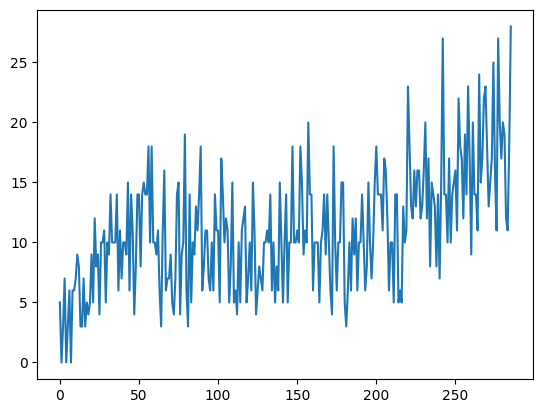

In [ ]:
# Get action
# Run step with action
# 
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np


perf_history = []
step = 0

for _ in range(1000):
    states, actions, values, log_probs, rewards, dones = [], [], [], [], [], []
    state, _ = env.reset()  # E x F x W x H
    done_all = torch.zeros(num_envs, dtype=torch.bool, device=device)
    
    perf = 0.0
    while not done_all.all():
        state = torch.tensor(state, dtype=torch.float32, device=device) / 255.0
        
        states.append(state)
        
        with torch.no_grad():
            action, value, log_prob, _ = agent.get_actions_or_values(state)
            actions.append(action)
            values.append(value.squeeze(1))
            log_probs.append(log_prob)
        
        next_state, reward, terminated, truncated, info = env.step(action.cpu().numpy())

        rewards.append(torch.tensor(reward, dtype=torch.float32, device=device))
        
        done = torch.tensor(np.logical_or(terminated, truncated), dtype=torch.bool, device=device)
        dones.append(done)

        done_all = torch.logical_or(done_all, done)
        
        state = next_state
        
        perf += reward.sum()
    perf_history.append(perf)
    step += 1
    last_state = torch.tensor(state, dtype=torch.float32, device=device) / 255.0

    # stack collected lists -> tensors
    states = torch.stack(states, dim=0).to(device)        # (T, N, C, H, W)
    actions = torch.stack(actions, dim=0).to(device)      # (T, N)
    values = torch.stack(values, dim=0).to(device)        # (T, N)
    log_probs = torch.stack(log_probs, dim=0).to(device)  # (T, N)
    rewards = torch.stack(rewards, dim=0).to(device)      # (T, N)
    dones = torch.stack(dones, dim=0).to(device)          # (T, N) bool

    agent.learn(states, actions, values, log_probs, rewards, dones, last_state)
    
    clear_output(wait=True)
    plt.plot(np.arange(step), perf_history)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch


def show_agent(agent, max_steps=500):
    env = gym.make('ALE/Breakout-v5', obs_type="grayscale", render_mode="rgb_array", frameskip=4)
    env = gym.wrappers.FrameStackObservation(env, stack_size=4)
    
    obs, _ = env.reset()
    total_reward = 0

    for step in range(max_steps):
        # Render from env
        frame = env.render()   # returns RGB array (H, W, 3)

        clear_output(wait=True)
        plt.imshow(frame)
        plt.axis("off")
        plt.title(f"Step {step}, Reward {total_reward}")
        plt.show()

        # Prepare observation for agent
        obs_t = torch.tensor(obs, dtype=torch.float32, device=device) / 255.0
        obs_t = obs_t.unsqueeze(0)

        # Choose action
        action, _, _, _ = agent.get_actions_or_values(obs_t)
        # Take environment step
        obs, reward, terminated, truncated, _ = env.step(action.item())
        total_reward += reward

        if terminated or truncated:
            break

    print("Episode finished. Total reward:", total_reward)
show_agent(agent)

In [ ]:
obs, _ = env.reset()
obs = torch.tensor(obs, dtype=torch.float32) / 255.0
states = torch.empty((0, *obs.shape[1:]))
action, log_prob, value = agent.get_action(obs)
next_obs, reward, terminated, truncated, _ = env.step(action)
print(truncated.shape)

In [ ]:
a = torch.tensor([1,2,3,4,5,6])
a[[3,2,1]]